In [169]:
from IPython.display import Markdown, display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

import traceback
import numpy as np
import scipy.stats as ss
import yaml
import itertools
import sys
import os
import subprocess
from os import path
import pickle
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from sklearn.linear_model import LinearRegression, TheilSenRegressor, RANSACRegressor, HuberRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline

def printmd(*args):
    display(Markdown(' '.join(map(str, args))))

In [170]:
# !ros2 run local_planning_performance_modelling compute_metrics -r "~/ds/performance_modelling/output/test_local_planning_gen_circles/*" -s

In [171]:
# !ros2 run local_planning_performance_modelling compute_metrics -r "~/ds/performance_modelling/output/test_local_planning/*" -s

In [172]:
local_planner_color = {'dwa': 'blue', 'arena': 'orange', 'teb': 'green'}
local_planner_symbol = {'dwa': 'o', 'arena': '^', 'teb': 'x'}
robot_model_color = {'hunter': 'cyan', 'turtle': 'green'}
pd.options.display.width = 200
pd.options.display.max_rows = 0
pd.options.display.float_format = '{:,.3f}'.format
plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams['lines.linewidth'] = 2


In [174]:
# df = pd.read_csv(path.expanduser("~/ds/performance_modelling/output/test_local_planning/results.csv"))
# with open(path.expanduser("~/ds/performance_modelling/output/test_local_planning/results_info.yaml")) as results_info_file:
#     results_info = yaml.safe_load(results_info_file)

df = pd.read_csv(path.expanduser("~/ds_alt/performance_modelling/output_plot_no_pedestrian_data/results.csv"))
with open(path.expanduser("~/ds_alt/performance_modelling/output_plot_no_pedestrian_data/results_info.yaml")) as results_info_file:
    results_info = yaml.safe_load(results_info_file)
    
df.rename(inplace=True, columns={
    'collisionless_localization_update_absolute_translation_error_mean': 'absolute_translation_error',
    'collisionless_localization_update_absolute_rotation_error_mean': 'absolute_rotation_error',
    'collisionless_localization_update_normalized_relative_translation_error_mean': 'normalized_relative_translation_error',
    'collisionless_localization_update_normalized_relative_rotation_error_mean': 'normalized_relative_rotation_error',
    'localization_update_rate_mean': 'localization_update_rate',
})

# turn odometry_error into beta_1..4
results_info['run_parameter_names'] += ['beta_1', 'beta_2', 'beta_3', 'beta_4']
results_info['run_parameter_names'].remove('odometry_error')
for i in range(0, 4):
    df[f'beta_{i+1}'] = df['odometry_error'].apply(lambda x: eval(x)[i])
del df['odometry_error']

df.loc[df.robot_model == 'turtlebot3_waffle_performance_modelling', 'robot_model'] = 'turtle'

run_parameters = [c for c in list(df.columns) if c in results_info['run_parameter_names']]
run_parameters += ['max_steering_angle_deg']
metrics_versions = [c for c in list(df.columns) if '_version' in c]
everything_else = ['run_id', 'session_id', 'run_number', 'goal_index']
metrics = [c for c in df.columns if c not in metrics_versions + run_parameters + everything_else]
metrics_and_versions = [c for c in list(df.columns) if '_version' in c or c in metrics]

cpu_time_metrics = [c for c in metrics if 'cpu_time' in c]
max_memory_metrics = [c for c in metrics if 'max_memory' in c]

# add useful parameters
df['session_id'] =  df['run_id'].apply(lambda x:  x.split('_')[1]+'_'+x.split('_')[2]+'_'+x.split('_')[3])
df['run_number'] =  df['run_id'].apply(lambda x:  int(x.split('_')[5]))
df[max_memory_metrics] = df[max_memory_metrics]/1024**2
df['max_steering_angle_deg'] = 90    # crea una nuova colonna e riempie le righe con il valore 90
df["run_index_str"] = df['run_index'].apply(lambda x: str(x))
df['goal_index'] = df.environment_name + '_' + df.run_index_str

# add metrics from existing ones
df['average_velocity'] = df['trajectory_length'] / df['execution_time']
df['success_rate'] = df['success_rate'] & (1 - df['collision_rate'])

metrics += ['average_velocity']
metrics_and_versions += ['average_velocity']

min_execution_time_group_df = df.groupby(["environment_name", "run_index", "success_rate"])
for (environment_name, run_index, success_rate), group_df in min_execution_time_group_df:
    df.loc[(df.environment_name == environment_name) & (df.run_index == run_index) & (success_rate), 'min_execution_time'] = group_df.execution_time.min()
df['norm_execution_time'] = df.execution_time / df.min_execution_time
metrics += ['norm_execution_time']
metrics_and_versions += ['norm_execution_time']

if True:
    printmd("## Number of Runs")
    printmd(f"    {len(df.run_id.unique())}")

    printmd("## Run Parameters")
    for name in [run_parameter_name for run_parameter_name in run_parameters if 'localization_generator_' not in run_parameter_name]:
        values = list(df[name].unique())
        printmd(f"    {name:<70}", sorted(values))

    printmd("## Metrics")
    for name in metrics_and_versions:
        if name in metrics_versions:
            if len(df[name].unique()) == 1:
                printmd(f"    {name:<70} {sorted(df[name].unique())}")
            else:
                printmd(f"<code><font style='background-color:yellow;font-family:monospace'>{name:<70}{sorted(df[name].unique())} </font></code> ⚠️")
        else:
            printmd(f"    {name:<70} min: {df[name].min(skipna=True):10.4g} {'avg':>15}: {df[name].mean(skipna=True):10.4g} {'max':>15}: {df[name].max(skipna=True):10.4g} {'nan':>15}: {sum(df[name].isna()):10.4g}")

## Number of Runs

    41

## Run Parameters

    amcl_alpha_factor                                                      [1.0]

    available_cpu_threads                                                  [4.0, nan]

    environment_name                                                       ['7A-2', 'airlab', 'fr079', 'intel', 'mexico', 'office_b']

    global_planner_node                                                    ['global_planner']

    local_planner_node                                                     ['arena', 'dwa', 'teb']

    localization_node                                                      ['amcl']

    min_turning_radius                                                     [0.0, 0.01, 0.1, nan]

    pedestrian_max_vel                                                     [0.3, 0.6, nan]

    pedestrian_number                                                      [0, 5, 100]

    robot_model                                                            ['turtle']

    run_index                                                              [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16]

    run_replication_index                                                  [0]

    beta_1                                                                 [0.01]

    beta_2                                                                 [0.0]

    beta_3                                                                 [0.01]

    beta_4                                                                 [0.0]

    max_steering_angle_deg                                                 [90]

## Metrics

    collision_rate                                                         min:          0             avg:     0.3902             max:          1             nan:          0

    collision_time                                                         min:      9.901             avg:       81.1             max:      201.4             nan:         25

    collision_rate_version                                                 [3]

    minimum_clearance                                                      min:          0             avg:     0.1852             max:      2.064             nan:          0

    average_clearance                                                      min:    0.01824             avg:     0.3327             max:      2.105             nan:          0

    median_clearance                                                       min:          0             avg:     0.2443             max:       2.11             nan:          0

    maximum_clearance                                                      min:     0.4732             avg:      1.373             max:      2.552             nan:          0

    clearance_version                                                      [3]

    trajectory_length                                                      min:     0.2507             avg:      29.14             max:      69.05             nan:          7

    trajectory_length_version                                              [1]

    execution_time                                                         min:       1.75             avg:      143.7             max:      462.7             nan:          7

    execution_time_version                                                 [1]

    success_rate                                                           min:          0             avg:     0.4634             max:          1             nan:          0

    success_rate_version                                                   [1]

    odometry_error_alpha_1_mean                                            min:   0.009019             avg:     0.1595             max:      1.543             nan:          8

    odometry_error_alpha_1_std                                             min:          0             avg:      1.092             max:      16.59             nan:          8

    odometry_error_alpha_2_mean                                            min:   0.003632             avg:     0.2864             max:      3.494             nan:          9

    odometry_error_alpha_2_std                                             min:   0.008781             avg:      1.245             max:      13.93             nan:          9

    odometry_error_alpha_3_mean                                            min:    0.01128             avg:    0.01922             max:    0.06765             nan:          9

    odometry_error_alpha_3_std                                             min:  0.0008188             avg:    0.04597             max:     0.3343             nan:          9

    odometry_error_alpha_4_mean                                            min:   0.004012             avg:    0.04841             max:     0.1504             nan:          8

    odometry_error_alpha_4_std                                             min:          0             avg:     0.1353             max:      1.479             nan:          8

    odometry_error_version                                                 [2]

    localization_update_absolute_translation_error_mean                    min:    0.03489             avg:      1.507             max:      46.04             nan:          7

    localization_update_absolute_translation_error_std                     min:    0.01246             avg:     0.4559             max:      11.43             nan:          7

    localization_update_absolute_rotation_error_mean                       min:   0.004161             avg:    0.08199             max:      1.733             nan:          7

    localization_update_absolute_rotation_error_std                        min:   0.003711             avg:     0.0895             max:     0.9002             nan:          7

    localization_update_relative_translation_error_mean                    min:   0.005595             avg:    0.01689             max:    0.04942             nan:          7

    localization_update_relative_translation_error_std                     min:   0.004463             avg:     0.0284             max:     0.1733             nan:          7

    localization_update_relative_rotation_error_mean                       min:   0.002652             avg:    0.03672             max:     0.6893             nan:          7

    localization_update_relative_rotation_error_std                        min:   0.002131             avg:    0.07989             max:     0.5779             nan:          7

    localization_update_normalized_relative_translation_error_mean         min:    0.05401             avg:      0.232             max:       1.31             nan:          9

    localization_update_normalized_relative_translation_error_std          min:    0.06918             avg:     0.5228             max:      6.362             nan:          9

    localization_update_normalized_relative_rotation_error_mean            min:    0.02058             avg:     0.1304             max:      1.085             nan:          8

    localization_update_normalized_relative_rotation_error_std             min:          0             avg:     0.4391             max:       4.33             nan:          8

    localization_update_error_version                                      [4]

    absolute_translation_error                                             min:    0.03085             avg:     0.1412             max:     0.5347             nan:          8

    collisionless_localization_update_absolute_translation_error_std       min:    0.01031             avg:    0.09737             max:     0.5966             nan:          8

    absolute_rotation_error                                                min:   0.004161             avg:    0.02955             max:    0.09653             nan:          8

    collisionless_localization_update_absolute_rotation_error_std          min:   0.003711             avg:    0.05722             max:     0.3905             nan:          8

    collisionless_localization_update_relative_translation_error_mean      min:   0.005595             avg:    0.01822             max:    0.09876             nan:          8

    collisionless_localization_update_relative_translation_error_std       min:   0.004776             avg:    0.02589             max:     0.2175             nan:          8

    collisionless_localization_update_relative_rotation_error_mean         min:   0.002652             avg:    0.01703             max:     0.1296             nan:          8

    collisionless_localization_update_relative_rotation_error_std          min:   0.002131             avg:    0.06155             max:     0.5458             nan:          8

    normalized_relative_translation_error                                  min:    0.05401             avg:     0.3756             max:      5.231             nan:          9

    collisionless_localization_update_normalized_relative_translation_error_std min:    0.01962             avg:     0.8807             max:      18.02             nan:          9

    normalized_relative_rotation_error                                     min:    0.01895             avg:     0.2246             max:      2.026             nan:          8

    collisionless_localization_update_normalized_relative_rotation_error_std min:          0             avg:      1.061             max:      19.15             nan:          8

    collisionless_localization_update_error_version                        [1]

    localization_update_rate                                               min:       0.02             avg:     0.9314             max:      3.891             nan:          7

    localization_update_rate_std                                           min:  8.757e-05             avg:     0.9696             max:      5.572             nan:          7

    localization_update_rate_version                                       [1]

    average_translation_velocity                                           min:    0.05135             avg:     0.2403             max:        1.1             nan:          7

    average_rotation_velocity                                              min:    0.03305             avg:     0.7512             max:      19.49             nan:          7

    translation_rotation_product                                           min:   0.006347             avg:     0.8512             max:      27.68             nan:          7

    average_translation_acceleration                                       min:    0.03405             avg:      0.179             max:      1.526             nan:          7

    average_rotation_acceleration                                          min:    0.05693             avg:     0.1988             max:     0.5274             nan:          7

    translation_rotation_acceleration_product                              min:   0.007507             avg:    0.06612             max:      0.974             nan:          7

    average_velocity_atan                                                  min:     0.1227             avg:     0.5759             max:      1.525             nan:          7

    motion_characteristics_version                                         [4]

    move_base_cpu_time                                                     min:       0.84             avg:      17.25             max:      84.02             nan:          0

    simulation_cpu_time                                                    min:      11.98             avg:        690             max:       3605             nan:          0

    system_cpu_time                                                        min:       3.17             avg:      125.5             max:       1253             nan:          0

    move_base_max_memory                                                   min:          0             avg:          0             max:          0             nan:          0

    simulation_max_memory                                                  min:      373.7             avg:      698.4             max:       1797             nan:          0

    system_max_memory                                                      min:      109.9             avg:      257.4             max:       1278             nan:          0

    cpu_time_and_max_memory_version                                        [3]

    max_cmd_vel_translation                                                min:        0.2             avg:     0.2529             max:       0.26             nan:          7

    max_cmd_vel_rotation                                                   min:          0             avg:     0.8652             max:      1.526             nan:          7

    mean_cmd_vel_translation                                               min:   0.003892             avg:     0.1918             max:     0.2599             nan:          7

    mean_cmd_vel_rotation                                                  min:    -0.8814             avg:   -0.01648             max:     0.2797             nan:          7

    cmd_vel_metrics_version                                                [2]

    dispersion                                                             min:      2.034             avg:      5.898             max:      11.76             nan:          0

    dispersion_version                                                     [1]

    normalized_curvature                                                   min:   0.005153             avg:     0.0707             max:     0.5485             nan:          7

    normalized_curvature_version                                           [1]

    average_velocity                                                       min:     0.0352             avg:      0.224             max:      1.285             nan:          7

    norm_execution_time                                                    min:          1             avg:      1.367             max:      7.107             nan:         19

In [186]:
df.groupby(by=['min_turning_radius', 'local_planner_node']).agg('mean')[['success_rate', 'collision_rate', 'move_base_cpu_time', 'move_base_max_memory']]
#df.groupby(by=('min_turning_radius', 'include_costmap_obstacles', 'include_dynamic_obstacles'))


success_rate  collision_rate  move_base_cpu_time  move_base_max_memory
min_turning_radius local_planner_node                                                                        
0.000              dwa                        0.300           0.500              23.116                 0.000
                   teb                        0.583           0.417              17.044                 0.000
0.010              dwa                        0.000           0.000               1.530                 0.000
0.100              teb                        0.667           0.250              10.018                 0.000

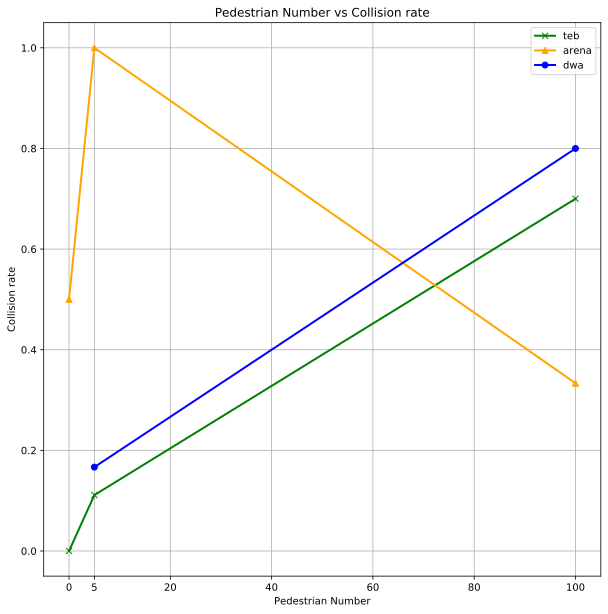

In [175]:
for local_planner_node in df.local_planner_node.unique():
    df_group = df[df.local_planner_node == local_planner_node].groupby(by='pedestrian_number')
    # raggruppiamo in base alla x e fai la media del collision rate
    df_collision_rate = df_group.agg('mean').collision_rate
    
    plt.plot(df_collision_rate.index, df_collision_rate, local_planner_symbol[local_planner_node] + '-', label=local_planner_node, color=local_planner_color[local_planner_node])
    
plt.xticks(sorted(list(set(range(0, 101, 20)).union(set([5])))))
plt.legend()
plt.xlabel('Pedestrian Number')
plt.ylabel('Collision rate')
plt.title('Pedestrian Number vs Collision rate')
plt.grid()
plt.show()

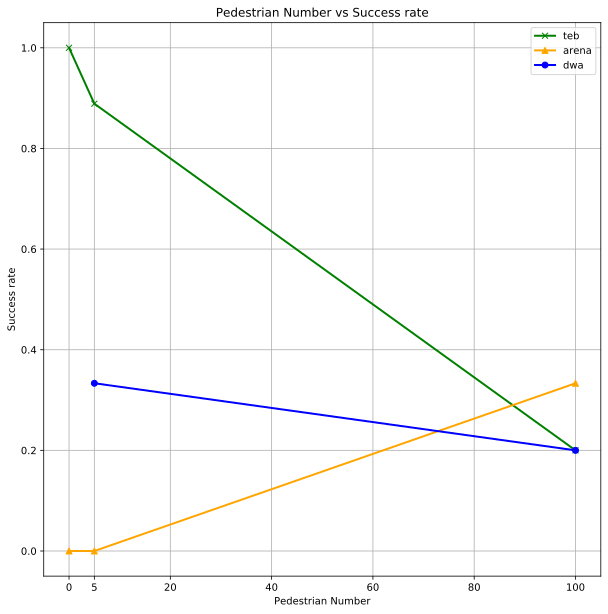

In [176]:
for local_planner_node in df.local_planner_node.unique():
    df_group = df[df.local_planner_node == local_planner_node].groupby(by = 'pedestrian_number')
    # raggruppiamo in base alla x e fai la media del collision rate
    df_success_rate = df_group.agg('mean').success_rate
    
    plt.plot(df_success_rate.index, df_success_rate, local_planner_symbol[local_planner_node] + '-', label=local_planner_node, color=local_planner_color[local_planner_node])
    
plt.xticks(sorted(list(set(range(0, 101, 20)).union(set([5])))))
plt.legend()
plt.xlabel('Pedestrian Number')
plt.ylabel('Success rate')
plt.title('Pedestrian Number vs Success rate')
plt.grid()
plt.show()

In [150]:
df_s_10 = df[(df.robot_model == 'turtle') & (df.localization_node == 'amcl') & (df.max_samples == 10)].copy()
df_s_20 = df[(df.robot_model == 'turtle') & (df.localization_node == 'amcl') & (df.max_samples == 20)].copy()

plt.plot(df.pede, df.average_velocity, 'b.-')


plt.title('TEB: Success rate vs  Number of samples')

plt.xticks(df.max_samples[::10])

plt.xlabel('max_samples')
plt.ylabel('average_velocity')
plt.legend()

plt.show()

AttributeError: 'DataFrame' object has no attribute 'max_samples'

In [22]:
df2 = df[(df.run_index == 15)]
df2['success_rate']
df

,run_id,amcl_alpha_factor,environment_name,global_planner_node,local_planner_node,localization_node,max_samples,min_turning_radius,pedestrian_max_vel,pedestrian_number,...,beta_3,beta_4,session_id,run_number,max_steering_angle_deg,run_index_str,goal_index,average_velocity,min_execution_time,norm_execution_time
0,session_2023-02-14_15-28-13_243746_run_000000000,1.000,7A-2,global_planner,teb,amcl,20,0.010,0.300,5,...,0.010,0.000,2023-02-14_15-28-13_243746,0,90,12,7A-2_12,0.258,145.598,1.005
1,session_2023-02-14_15-28-13_243746_run_000000001,1.000,7A-2,global_planner,teb,amcl,10,0.010,0.300,5,...,0.010,0.000,2023-02-14_15-28-13_243746,1,90,7,7A-2_7,0.263,134.600,1.013
2,session_2023-02-14_15-28-13_243746_run_000000002,1.000,7A-2,global_planner,teb,amcl,20,0.010,0.300,5,...,0.010,0.000,2023-02-14_15-28-13_243746,2,90,2,7A-2_2,0.265,19.097,1.000
3,session_2023-02-14_15-28-13_243746_run_000000003,1.000,7A-2,global_planner,teb,amcl,10,0.010,0.300,5,...,0.010,0.000,2023-02-14_15-28-13_243746,3,90,2,7A-2_2,0.256,19.097,1.021
4,session_2023-02-14_15-28-13_243746_run_000000004,1.000,7A-2,global_planner,teb,amcl,20,0.010,0.300,5,...,0.010,0.000,2023-02-14_15-28-13_243746,4,90,14,7A-2_14,0.261,160.748,1.013
5,session_2023-02-14_15-28-13_243746_run_000000005,1.000,7A-2,global_planner,teb,amcl,20,0.010,0.300,5,...,0.010,0.000,2023-02-14_15-28-13_243746,5,90,5,7A-2_5,0.253,114.539,1.076
6,session_2023-02-14_15-28-13_243746_run_000000006,1.000,7A-2,global_planner,teb,amcl,20,0.010,0.300,5,...,0.010,0.000,2023-02-14_15-28-13_243746,6,90,7,7A-2_7,0.266,134.600,1.000
7,session_2023-02-14_15-28-13_243746_run_000000007,1.000,7A-2,global_planner,teb,amcl,20,0.010,0.300,5,...,0.010,0.000,2023-02-14_15-28-13_243746,7,90,1,7A-2_1,0.259,217.696,1.014
8,session_2023-02-14_15-28-13_243746_run_000000008,1.000,7A-2,global_planner,teb,amcl,20,0.010,0.300,5,...,0.010,0.000,2023-02-14_15-28-13_243746,8,90,0,7A-2_0,0.228,315.098,0.559
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [10]:
df[["run_id", "local_planner_node", "success_rate", "normalized_curvature"]]

,run_id,local_planner_node,success_rate,normalized_curvature
0,session_2023-02-14_15-28-13_243746_run_000000000,teb,1,0.008
1,session_2023-02-14_15-28-13_243746_run_000000001,teb,1,0.008
2,session_2023-02-14_15-28-13_243746_run_000000002,teb,1,0.046
3,session_2023-02-14_15-28-13_243746_run_000000003,teb,1,0.030
4,session_2023-02-14_15-28-13_243746_run_000000004,teb,1,0.008
5,session_2023-02-14_15-28-13_243746_run_000000005,teb,1,0.028
6,session_2023-02-14_15-28-13_243746_run_000000006,teb,1,0.007
7,session_2023-02-14_15-28-13_243746_run_000000007,teb,1,0.007
8,session_2023-02-14_15-28-13_243746_run_000000008,teb,0,0.010
...,...,...,...,...


In [11]:
df2 = df[(df.max_samples == 20)]
df2[["run_id", "environment_name", "run_index", "success_rate"]]


,run_id,environment_name,run_index,success_rate
0,session_2023-02-14_15-28-13_243746_run_000000000,7A-2,12,1
2,session_2023-02-14_15-28-13_243746_run_000000002,7A-2,2,1
4,session_2023-02-14_15-28-13_243746_run_000000004,7A-2,14,1
5,session_2023-02-14_15-28-13_243746_run_000000005,7A-2,5,1
6,session_2023-02-14_15-28-13_243746_run_000000006,7A-2,7,1
7,session_2023-02-14_15-28-13_243746_run_000000007,7A-2,1,1
8,session_2023-02-14_15-28-13_243746_run_000000008,7A-2,0,0
9,session_2023-02-14_15-28-13_243746_run_000000009,7A-2,6,0
12,session_2023-02-14_15-28-13_243746_run_000000012,7A-2,9,1
13,session_2023-02-14_15-28-13_243746_run_000000013,7A-2,3,1


In [12]:
df[['run_id', 'collision_rate']]

,run_id,collision_rate
0,session_2023-02-14_15-28-13_243746_run_000000000,0
1,session_2023-02-14_15-28-13_243746_run_000000001,0
2,session_2023-02-14_15-28-13_243746_run_000000002,0
3,session_2023-02-14_15-28-13_243746_run_000000003,0
4,session_2023-02-14_15-28-13_243746_run_000000004,0
5,session_2023-02-14_15-28-13_243746_run_000000005,0
6,session_2023-02-14_15-28-13_243746_run_000000006,0
7,session_2023-02-14_15-28-13_243746_run_000000007,0
8,session_2023-02-14_15-28-13_243746_run_000000008,0
...,...,...


In [13]:
# restituisce tutte le righe aventi arena e collision rate pari a 1. Ho splittato in 2 istruzioni come consigliato su stackoverflow, per evitare warning.
df2 = df[df.local_planner_node =='teb'] 
df2[df2.collision_rate == 1]

# scarta riga se c'è un nan nella metrica

,run_id,amcl_alpha_factor,environment_name,global_planner_node,local_planner_node,localization_node,max_samples,min_turning_radius,pedestrian_max_vel,pedestrian_number,...,beta_3,beta_4,session_id,run_number,max_steering_angle_deg,run_index_str,goal_index,average_velocity,min_execution_time,norm_execution_time


In [14]:
df[ (df.local_planner_node =='teb') & (df.success_rate == 1) ] 
# questo non scarta le righe contenenti i nan

,run_id,amcl_alpha_factor,environment_name,global_planner_node,local_planner_node,localization_node,max_samples,min_turning_radius,pedestrian_max_vel,pedestrian_number,...,beta_3,beta_4,session_id,run_number,max_steering_angle_deg,run_index_str,goal_index,average_velocity,min_execution_time,norm_execution_time
0,session_2023-02-14_15-28-13_243746_run_000000000,1.000,7A-2,global_planner,teb,amcl,20,0.010,0.300,5,...,0.010,0.000,2023-02-14_15-28-13_243746,0,90,12,7A-2_12,0.258,145.598,1.005
1,session_2023-02-14_15-28-13_243746_run_000000001,1.000,7A-2,global_planner,teb,amcl,10,0.010,0.300,5,...,0.010,0.000,2023-02-14_15-28-13_243746,1,90,7,7A-2_7,0.263,134.600,1.013
2,session_2023-02-14_15-28-13_243746_run_000000002,1.000,7A-2,global_planner,teb,amcl,20,0.010,0.300,5,...,0.010,0.000,2023-02-14_15-28-13_243746,2,90,2,7A-2_2,0.265,19.097,1.000
3,session_2023-02-14_15-28-13_243746_run_000000003,1.000,7A-2,global_planner,teb,amcl,10,0.010,0.300,5,...,0.010,0.000,2023-02-14_15-28-13_243746,3,90,2,7A-2_2,0.256,19.097,1.021
4,session_2023-02-14_15-28-13_243746_run_000000004,1.000,7A-2,global_planner,teb,amcl,20,0.010,0.300,5,...,0.010,0.000,2023-02-14_15-28-13_243746,4,90,14,7A-2_14,0.261,160.748,1.013
5,session_2023-02-14_15-28-13_243746_run_000000005,1.000,7A-2,global_planner,teb,amcl,20,0.010,0.300,5,...,0.010,0.000,2023-02-14_15-28-13_243746,5,90,5,7A-2_5,0.253,114.539,1.076
6,session_2023-02-14_15-28-13_243746_run_000000006,1.000,7A-2,global_planner,teb,amcl,20,0.010,0.300,5,...,0.010,0.000,2023-02-14_15-28-13_243746,6,90,7,7A-2_7,0.266,134.600,1.000
7,session_2023-02-14_15-28-13_243746_run_000000007,1.000,7A-2,global_planner,teb,amcl,20,0.010,0.300,5,...,0.010,0.000,2023-02-14_15-28-13_243746,7,90,1,7A-2_1,0.259,217.696,1.014
10,session_2023-02-14_15-28-13_243746_run_000000010,1.000,7A-2,global_planner,teb,amcl,10,0.010,0.300,5,...,0.010,0.000,2023-02-14_15-28-13_243746,10,90,1,7A-2_1,0.261,217.696,1.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [15]:
len(df2[df2.collision_rate == 1]) #restituisce il numero di righe

0

In [16]:
# alternativa se non si vogliono considerare i null values
df2[df2.collision_rate == 1].count()

run_id                    0
amcl_alpha_factor         0
environment_name          0
global_planner_node       0
local_planner_node        0
localization_node         0
max_samples               0
min_turning_radius        0
pedestrian_max_vel        0
pedestrian_number         0
robot_model               0
run_index                 0
                         ..
beta_1                    0
beta_2                    0
beta_3                    0
beta_4                    0
session_id                0
run_number                0
max_steering_angle_deg    0
run_index_str             0
goal_index                0
average_velocity          0
min_execution_time        0
norm_execution_time       0
Length: 99, dtype: int64

In [17]:
printmd("## Overall performance values by robot model, local planner component, kinematic constraints, and localization component")
printmd("### Considering all runs (sorted by collisionless success rate)")
df.groupby(['robot_model', 'local_planner_node', 'max_steering_angle_deg', 'localization_node'])[["success_rate", "collision_rate", "average_velocity", "norm_execution_time"]].agg(['mean', 'count']).sort_values(('success_rate', 'mean'), ascending=False)

## Overall performance values by robot model, local planner component, kinematic constraints, and localization component

### Considering all runs (sorted by collisionless success rate)

success_rate       collision_rate       average_velocity       norm_execution_time      
                                                                                mean count           mean count             mean count                mean count
robot_model local_planner_node max_steering_angle_deg localization_node                                                                                         
turtle      teb                90                     amcl                     0.765    34              0    34            0.245    34               0.954    30

In [18]:
printmd("### Only considering successful runs (sorted by norm execution time)")
df[df.success_rate == 1].groupby(['robot_model', 'local_planner_node', 'max_steering_angle_deg', 'localization_node'])[["success_rate", "collision_rate", "average_velocity", "norm_execution_time"]].agg(['mean', 'count']).sort_values(('norm_execution_time', 'mean'), ascending=True)

### Only considering successful runs (sorted by norm execution time)

success_rate       collision_rate       average_velocity       norm_execution_time      
                                                                                mean count           mean count             mean count                mean count
robot_model local_planner_node max_steering_angle_deg localization_node                                                                                         
turtle      teb                90                     amcl                         1    26              0    26            0.259    26               1.010    26

In [19]:
printmd("### Only considering failed runs (sorted by collision rate)")
df[df.success_rate == 0].groupby(['robot_model', 'local_planner_node', 'max_steering_angle_deg', 'localization_node'])[["success_rate", "collision_rate", "average_velocity", "norm_execution_time"]].agg(['mean', 'count']).sort_values(('collision_rate', 'mean'), ascending=True)

### Only considering failed runs (sorted by collision rate)

success_rate       collision_rate       average_velocity       norm_execution_time      
                                                                                mean count           mean count             mean count                mean count
robot_model local_planner_node max_steering_angle_deg localization_node                                                                                         
turtle      teb                90                     amcl                         0     8              0     8            0.199     8               0.587     4

## success rate

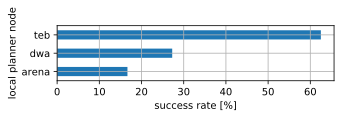

## collision_rate

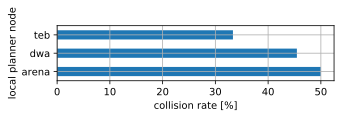

## average_velocity, only successful runs

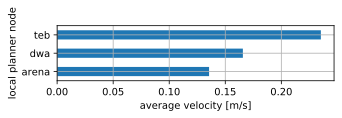

## norm_execution_time, only successful runs

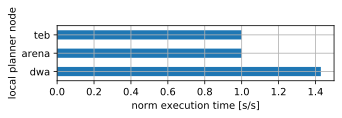

In [156]:
def bar_plot(metric_name, selected_df, y_columns=['local_planner_node'], percentage=False, unit_symbol=None, higher_better=True):
    bar_df = selected_df.groupby(y_columns)[metric_name].agg(['mean', 'count']).sort_values(by=('mean'), ascending=higher_better)
    ax = (bar_df.sort_values(by=('mean'), ascending=higher_better)* (100 if percentage else 1) ).plot.barh(y=[('mean')], stacked=True, figsize=[10, 5], grid=True, legend=False)
    ax.set_xlabel(metric_name.replace('_', ' ').replace(',', ', ') + (f" [{unit_symbol}]" if unit_symbol else ""))
    ax.set_ylabel(ax.get_ylabel().replace('_', ' ').replace(',', ',\n'))
    plt.gcf().set_size_inches([5, 1])
    plt.show()
printmd("## success rate")
bar_plot(metric_name='success_rate', selected_df=df[(df.max_steering_angle_deg == 90.0)], percentage=True, higher_better=True, unit_symbol='%')
printmd("## collision_rate")
bar_plot(metric_name='collision_rate', selected_df=df[(df.max_steering_angle_deg == 90.0)], percentage=True, higher_better=False, unit_symbol='%')
printmd("## average_velocity, only successful runs")
bar_plot(metric_name='average_velocity', selected_df=df[(df.success_rate == 1) & (df.max_steering_angle_deg == 90.0)], higher_better=True, unit_symbol='m/s')
printmd("## norm_execution_time, only successful runs")
bar_plot(metric_name='norm_execution_time', selected_df=df[(df.success_rate == 1) & (df.max_steering_angle_deg == 90.0)], higher_better=False, unit_symbol='s/s')

In [21]:
max_scatter_points = 200
def plot_in_out_metrics_bin_width_save(output_metric, input_metrics, bin_widths, min_bin_count, selected_df, out_dir, min_y=0.0, plot_all=True, scatter=True):
    max_y = -np.inf
#     scatter = False

    for i, (input_metric, bin_width) in enumerate(zip(input_metrics, bin_widths)):
        fig = plt.figure()

        for localization_node in df.localization_node.unique():
            for local_planner_node in df.local_planner_node.unique():
                
                df_lr = selected_df[
                    (selected_df.localization_node == localization_node) & 
                    (selected_df.local_planner_node == local_planner_node) & 
                    selected_df[input_metric.name].notna() & 
                    selected_df[output_metric.name].notna()
                ].copy()
                if len(df_lr[input_metric.name]):
                    if scatter:
                        n = max(1, int(len(df_lr[input_metric.name])/max_scatter_points))
                        plt.scatter(df_lr[input_metric.name][::n], df_lr[output_metric.name][::n], marker='.', s=0.25, color=local_planner_color[local_planner_node])
                    
                    if bin_width is not None:
                        if isinstance(bin_width, str):
                            _, bins = np.histogram(df_lr[input_metric.name], bins=bin_width)
                        else:
                            bins = np.arange(0., input_metric.max() + bin_width, bin_width)

                        df_lr['x_range'] = pd.cut(df_lr[input_metric.name], bins, labels=bins[:-1]).astype('float')
                        df_lr_g = df_lr.groupby('x_range').agg(['mean', 'count'])
                        df_lr_g = df_lr_g[ df_lr_g[(output_metric.name, 'count')] > min_bin_count ]
                        plt.plot(df_lr_g.index, df_lr_g[(output_metric.name, 'mean')], f'{local_planner_symbol[local_planner_node]}-', fillstyle='none', mfc=None, label=f'{local_planner_node}', linewidth=1, color=local_planner_color[local_planner_node])
                    else:
                        df_lr_g = df_lr.groupby(input_metric.name).agg(['mean', 'count'])
                        df_lr_g = df_lr_g[ df_lr_g[(output_metric.name, 'count')] > min_bin_count ]
                        plt.plot(df_lr_g.index, df_lr_g[(output_metric.name, 'mean')], f'{local_planner_symbol[local_planner_node]}-', fillstyle='none', mfc=None, label=f'{local_planner_node}', linewidth=1, color=local_planner_color[local_planner_node])
                    max_y = max(max_y, df_lr_g[(output_metric.name, 'mean')].max())

        if i == 0:
            plt.legend()
        plt.grid()
        plt.xlabel(input_metric.name.replace('_', ' '))
        plt.ylabel(output_metric.name.replace('_', ' '))
        plt.ylim([min_y, max_y*1.1])
        fig.set_size_inches([4, 4])
        if not path.exists(out_dir):
            os.makedirs(out_dir)
        fig.savefig(out_dir + f"/{output_metric.name}---{input_metric.name}.pdf".replace('_', '-'), bbox_inches='tight')
        plt.show()


In [2]:
printmd("## Localization perf from system features")

d = df[(df.max_steering_angle_deg == 90.) & (df.robot_model == 'turtle') & (df.global_planner_node == 'navfn') & (df.localization_node == 'amcl')].copy()
min_bin_count = 10
input_metrics, bin_widths = zip(*[
    [d.average_velocity, 0.02], 
    [d.average_translation_velocity, 0.02], 
    #[d.average_velocity_atan, 0.1],
    [d.beta_1, None],
])
output_metrics = [
    d.absolute_translation_error,
    d.absolute_rotation_error,
    d.normalized_relative_translation_error,
    d.normalized_relative_rotation_error,
]
for output_metric in output_metrics:
    printmd(f"### {output_metric.name.replace('_', ' ')}")
    plot_in_out_metrics_bin_width_save(
        output_metric=output_metric, 
        input_metrics=input_metrics, 
        bin_widths=bin_widths,
        min_bin_count=min_bin_count,
        selected_df=d,
        out_dir="thesis_plots/localization",
    )


printmd("## Localization perf from own parameters")

d = df[(df.max_steering_angle_deg == 90.) & (df.robot_model == 'turtle') & (df.global_planner_node == 'navfn') & (df.localization_node == 'amcl') & (df.amcl_alpha_factor != 0)].copy()
min_bin_count = 10
input_metrics, bin_widths = zip(*[
    [d.amcl_alpha_factor, None],
])
output_metrics = [
    d.absolute_translation_error,
    d.absolute_rotation_error,
    d.normalized_relative_translation_error,
    d.normalized_relative_rotation_error,
]
for output_metric in output_metrics:
    printmd(f"### {output_metric.name.replace('_', ' ')}")
    plot_in_out_metrics_bin_width_save(
        output_metric=output_metric, 
        input_metrics=input_metrics, 
        bin_widths=bin_widths,
        min_bin_count=min_bin_count,
        selected_df=d,
        out_dir="thesis_plots/localization",
    )

NameError: name 'printmd' is not defined

In [ ]:
# printmd("## avg vel and avg vel atan are similar")
# d = df[(df.max_steering_angle_deg == 90.) & (df.robot_model == 'turtle') & (df.global_planner_node == 'navfn') & (df.localization_node == 'amcl')].copy()
# input_metrics = [
#     d.average_translation_velocity,
#     d.average_rotation_velocity,
#     d.average_velocity_atan,
# ]
# bin_widths = [0.02, 0.05, 0.1]
# min_bin_count = 10
# plot_in_out_metrics_bin_width_save(
#     output_metric=d.average_translation_velocity, 
#     input_metrics=input_metrics, 
#     bin_widths=bin_widths,
#     min_bin_count=min_bin_count,
#     selected_df=d,
#     scatter=True,
#     out_dir="thesis_plots/motion_char_self_correlation",
# )
# plot_in_out_metrics_bin_width_save(
#     output_metric=d.average_rotation_velocity, 
#     input_metrics=input_metrics, 
#     bin_widths=bin_widths,
#     min_bin_count=min_bin_count,
#     selected_df=d,
#     scatter=True,
#     out_dir="thesis_plots/motion_char_self_correlation",
# )
# plot_in_out_metrics_bin_width_save(
#     output_metric=d.average_velocity_atan, 
#     input_metrics=input_metrics, 
#     bin_widths=bin_widths,
#     min_bin_count=min_bin_count,
#     selected_df=d,
#     scatter=True,
#     out_dir="thesis_plots/motion_char_self_correlation",
# )

In [ ]:
# print(df.goal_index)

bin_widths = [None, None, None]
d = df[(df.max_steering_angle_deg == 90.) & (df.robot_model == 'turtle') & (df.global_planner_node == 'navfn') & (df.localization_node == 'amcl')].copy()
input_metrics = [
    d.environment_name,
    d.run_duplicate_index,
    d.goal_index,
]

plot_in_out_metrics_bin_width_save(
    output_metric=d.minimum_clearance, 
    input_metrics=input_metrics, 
    bin_widths=bin_widths,
    min_bin_count=10,
    selected_df=d,
    plot_all=False,
    scatter=False,
    out_dir="thesis_plots/local_planner",
)
plot_in_out_metrics_bin_width_save(
    output_metric=d.average_velocity, 
    input_metrics=input_metrics, 
    bin_widths=bin_widths,
    min_bin_count=10,
    selected_df=d,
    plot_all=False,
    scatter=False,
    out_dir="thesis_plots/local_planner",
)

In [ ]:

# printmd("### norm trajectory length ← absolute translation error doesn't work because when absolute translation error is very small, the trajectories are very short and a small change in trajectory length causes a big change in norm trajectory length")

# for e in df.environment_name.unique():
#     printmd(f"## {e}")
#     bin_widths = [0.01]
#     min_bin_count = 10
#     d = df[(df.success_rate == 1) & (df.max_steering_angle_deg == 90.) & (df.robot_model == 'turtle') & (df.global_planner_node == 'navfn') & (df.localization_node == 'amcl') & (df.environment_name == e)].copy()
#     input_metrics = [
#         d.absolute_translation_error, 
#     ]
#     plot_in_out_metrics_bin_width_save(
#         output_metric=d.min_trajectory_length, 
#         input_metrics=input_metrics, 
#         bin_widths=bin_widths,
#         min_bin_count=min_bin_count,
#         selected_df=d,
#         plot_all=False,
#         scatter=False,
#         out_dir=f"thesis_plots/local_planner/{e}",
#     )
    
#     plot_in_out_metrics_bin_width_save(
#         output_metric=d.trajectory_length, 
#         input_metrics=input_metrics, 
#         bin_widths=bin_widths,
#         min_bin_count=min_bin_count,
#         selected_df=d,
#         plot_all=False,
#         scatter=False,
#         out_dir=f"thesis_plots/local_planner/{e}",
#     )
#     plot_in_out_metrics_bin_width_save(
#         output_metric=d.norm_trajectory_length, 
#         input_metrics=input_metrics, 
#         bin_widths=bin_widths,
#         min_bin_count=min_bin_count,
#         selected_df=d,
#         plot_all=False,
#         min_y=1.0,
#         scatter=False,
#         out_dir=f"thesis_plots/local_planner/{e}",
#     )


In [ ]:

# printmd("### norm trajectory length, trajectory length ← other localization error metrics")

# for e in df.environment_name.unique():
#     printmd(f"## {e}")
#     bin_widths = [0.03]
#     min_bin_count = 10
#     d = df[(df.success_rate == 1) & (df.max_steering_angle_deg == 90.) & (df.robot_model == 'turtle') & (df.global_planner_node == 'navfn') & (df.localization_node == 'amcl') & (df.environment_name == e)].copy()
#     input_metrics = [
#         d.normalized_relative_rotation_error, 
#     ]
#     plot_in_out_metrics_bin_width_save(
#         output_metric=d.min_trajectory_length, 
#         input_metrics=input_metrics, 
#         bin_widths=bin_widths,
#         min_bin_count=min_bin_count,
#         selected_df=d,
#         plot_all=False,
#         scatter=False,
#         out_dir=f"thesis_plots/local_planner/{e}",
#     )
#     plot_in_out_metrics_bin_width_save(
#         output_metric=d.trajectory_length, 
#         input_metrics=input_metrics, 
#         bin_widths=bin_widths,
#         min_bin_count=min_bin_count,
#         selected_df=d,
#         plot_all=False,
#         scatter=False,
#         out_dir=f"thesis_plots/local_planner/{e}",
#     )
#     plot_in_out_metrics_bin_width_save(
#         output_metric=d.norm_trajectory_length, 
#         input_metrics=input_metrics, 
#         bin_widths=bin_widths,
#         min_bin_count=min_bin_count,
#         selected_df=d,
#         plot_all=False,
#         min_y=1.0,
#         scatter=False,
#         out_dir=f"thesis_plots/local_planner/{e}",
#     )


## 7A-2

No handles with labels found to put in legend.


ValueError: Axis limits cannot be NaN or Inf

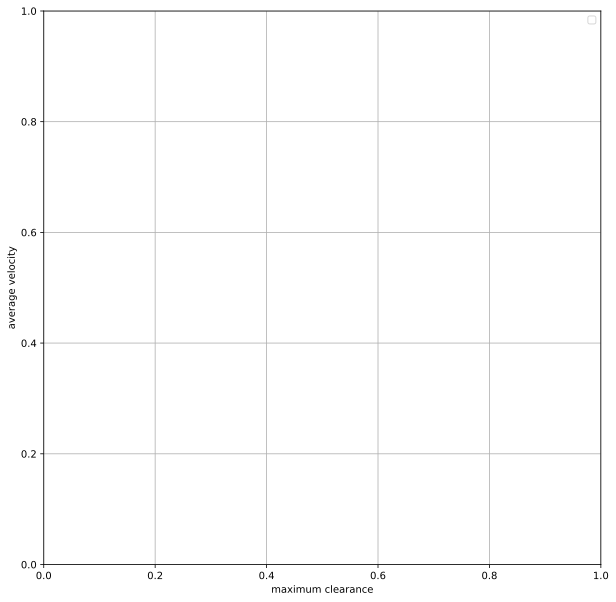

In [66]:


for e in df.environment_name.unique():
    printmd(f"## {e}")
    min_bin_count = 10
    d = df[(df.max_steering_angle_deg == 90.) & (df.robot_model == 'turtle') & (df.global_planner_node == 'navfn') & (df.localization_node == 'amcl') & (df.environment_name == e)].copy()
    bin_widths = [1, .1, .01]
    input_metrics = [
        d.maximum_clearance, 
        d.average_clearance, 
        d.minimum_clearance, 
    ]
    plot_in_out_metrics_bin_width_save(
        output_metric=d.average_velocity, 
        input_metrics=input_metrics, 
        bin_widths=bin_widths,
        min_bin_count=min_bin_count,
        selected_df=d,
        min_y=0.0,
        plot_all=False,
        scatter=True,
        out_dir=f"thesis_plots/local_planner/{e}",
    )


In [ ]:

printmd("## Local Planning perf (also system features)")

min_bin_count = 10
d = df[(df.success_rate == 1) & (df.max_steering_angle_deg == 90.) & (df.robot_model == 'turtle') & (df.global_planner_node == 'navfn') & (df.localization_node == 'amcl')].copy()
input_metrics, bin_widths = zip(*[
    [d.beta_1, None], 
    [d.amcl_alpha_factor, None],
    [d.minimum_clearance, .1],
    [d.average_clearance, 1],
])
plot_in_out_metrics_bin_width_save(
    output_metric=d.average_velocity, 
    input_metrics=input_metrics, 
    bin_widths=bin_widths,
    min_bin_count=min_bin_count,
    selected_df=d,
    plot_all=False,
    scatter=True,
    out_dir="thesis_plots/local_planner",
)
plot_in_out_metrics_bin_width_save(
    output_metric=d.average_velocity_atan, 
    input_metrics=input_metrics, 
    bin_widths=bin_widths,
    min_bin_count=min_bin_count,
    selected_df=d,
    plot_all=False,
    scatter=True,
    out_dir="thesis_plots/local_planner",
)

In [ ]:
## plots_local_planner

printmd("## Local Planning perf (not system features)")

min_bin_count = 10

d = df[(df.max_steering_angle_deg == 90.) & (df.robot_model == 'turtle') & (df.global_planner_node == 'navfn') & (df.localization_node == 'amcl')].copy()
input_metrics, bin_widths = zip(*[
    [d.beta_1, None], 
    [d.amcl_alpha_factor, None],
    [d.average_clearance, 1],
])
plot_in_out_metrics_bin_width_save(
    output_metric=d.success_rate, 
    input_metrics=input_metrics, 
    bin_widths=bin_widths,
    min_bin_count=min_bin_count,
    selected_df=d,
    out_dir="thesis_plots/local_planner",
    plot_all=False,
)
plot_in_out_metrics_bin_width_save(
    output_metric=d.collision_rate, 
    input_metrics=input_metrics, 
    bin_widths=bin_widths,
    min_bin_count=min_bin_count,
    selected_df=d,
    out_dir="thesis_plots/local_planner",
    plot_all=False,
)

d = df[(df.success_rate == 1) & (df.max_steering_angle_deg == 90.) & (df.robot_model == 'turtle') & (df.global_planner_node == 'navfn') & (df.localization_node == 'amcl')].copy()
input_metrics, bin_widths = zip(*[
    [d.beta_1, None], 
    [d.amcl_alpha_factor, None],
    [d.minimum_clearance, .1],
    [d.average_clearance, 1],
])
plot_in_out_metrics_bin_width_save(
    output_metric=d.norm_trajectory_length, 
    input_metrics=input_metrics, 
    bin_widths=bin_widths,
    min_bin_count=min_bin_count,
    selected_df=d,
    min_y=1.0,
    plot_all=False,
    out_dir="thesis_plots/local_planner",
)
plot_in_out_metrics_bin_width_save(
    output_metric=d.norm_execution_time, 
    input_metrics=input_metrics, 
    bin_widths=bin_widths,
    min_bin_count=min_bin_count,
    selected_df=d,
    min_y=1.0,
    plot_all=False,
    out_dir="thesis_plots/local_planner",
)

In [ ]:
# ## plots_local_planner

# min_bin_count = 10

# d = df[(df.success_rate == 1) & (df.max_steering_angle_deg == 90.) & (df.robot_model == 'turtle') & (df.global_planner_node == 'navfn') & (df.localization_node == 'amcl')].copy()
# input_metrics, bin_widths = zip(*[
# #     [d.beta_1, None], 
# #     [d.amcl_alpha_factor, None],
# #     [d.minimum_clearance, .1],
# #     [d.average_clearance, 1],
#     [d.absolute_translation_error, 0.05],
#     [d.absolute_rotation_error, 0.01],
#     [d.normalized_relative_translation_error, 0.05],
#     [d.normalized_relative_rotation_error, 0.05],
# ])

# printmd("## norm_trajectory_length")
# plot_in_out_metrics_bin_width_save(
#     output_metric=d.norm_trajectory_length, 
#     input_metrics=input_metrics, 
#     bin_widths=bin_widths,
#     min_bin_count=min_bin_count,
#     selected_df=d,
#     min_y=1.0,
#     plot_all=False,
#     scatter=True,
#     out_dir="thesis_plots/local_planner",
# )
# printmd("## norm_trajectory_length_std")
# plot_in_out_metrics_bin_width_save(
#     output_metric=d.norm_trajectory_length_std, 
#     input_metrics=input_metrics, 
#     bin_widths=bin_widths,
#     min_bin_count=min_bin_count,
#     selected_df=d,
#     min_y=1.0,
#     plot_all=False,
#     scatter=True,
#     out_dir="thesis_plots/local_planner",
# )
# printmd("## norm_trajectory_length_mean")
# plot_in_out_metrics_bin_width_save(
#     output_metric=d.norm_trajectory_length_mean, 
#     input_metrics=input_metrics, 
#     bin_widths=bin_widths,
#     min_bin_count=min_bin_count,
#     selected_df=d,
# #     min_y=1.0,
#     plot_all=False,
#     scatter=True,
#     out_dir="thesis_plots/local_planner",
# )
# printmd("## norm_trajectory_length_median")
# plot_in_out_metrics_bin_width_save(
#     output_metric=d.norm_trajectory_length_median, 
#     input_metrics=input_metrics, 
#     bin_widths=bin_widths,
#     min_bin_count=min_bin_count,
#     selected_df=d,
# #     min_y=1.0,
#     plot_all=False,
#     scatter=True,
#     out_dir="thesis_plots/local_planner",
# )

In [67]:
df_s = df[(df.success_rate == 1) & (df.max_steering_angle_deg == 90.) & (df.robot_model == 'turtle') & (df.global_planner_node == 'navfn') & (df.localization_node == 'amcl')].copy()

bins = np.arange(df_s.trajectory_length.min(), df_s.trajectory_length.max(), 5)
df_s['trajectory_length_d'] = pd.cut(df_s.trajectory_length, bins, labels=bins[:-1]).astype('float')
df_lr_g = df_s.groupby('trajectory_length_d').agg(['mean', 'count'])

plt.plot(df_lr_g.index, df_lr_g[('absolute_translation_error', 'mean')], label='all', color='black', linewidth=4)

for environment_name in df_s.environment_name.unique():
    df_lr_g = df_s[df_s.environment_name == environment_name].groupby('trajectory_length_d').agg(['mean', 'count'])
    plt.plot(df_lr_g.index, df_lr_g[('absolute_translation_error', 'mean')], label=environment_name)

plt.xlabel('trajectory_length_d')
plt.ylabel('absolute_translation_error')
plt.legend()
plt.grid()
plt.show()

ValueError: arange: cannot compute length

    trajectory_length_d  trajectory_length
0                29.720             29.720
1                 4.907              4.907
2                43.463             43.463
3                25.047             25.047
4                24.276             24.276
5                   nan                nan
6                37.561             37.561
7                23.860             23.860
8                39.187             39.187
..                  ...                ...
32               24.278             24.278
33               62.870             62.870
34                  nan                nan
35                3.712              3.712
36                6.434              6.434
37                  nan                nan
38               58.531             58.531
39               37.818             37.818
40                  nan                nan

[41 rows x 2 columns]


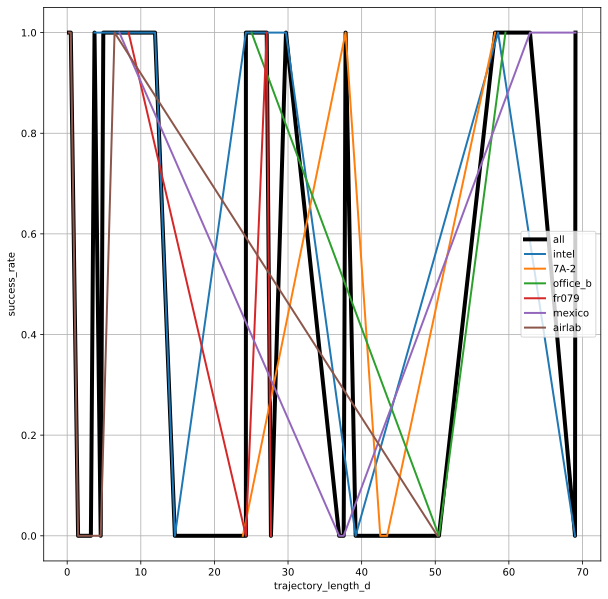

In [167]:
df_s = df.copy()

bins = np.arange(0, 100, 5)
# df_s['trajectory_length_d'] = pd.cut(df_s.trajectory_length, bins, labels=bins[:-1]).astype('float')
df_s['trajectory_length_d'] = df_s['trajectory_length']
print(df_s[['trajectory_length_d', 'trajectory_length']])
df_lr_g = df_s.groupby('trajectory_length_d').agg(['mean', 'count'])

plt.plot(df_lr_g.index, df_lr_g[('success_rate', 'mean')], label='all', color='black', linewidth=4)

for environment_name in df_s.environment_name.unique():
    df_lr_g = df_s[df_s.environment_name == environment_name].groupby('trajectory_length_d').agg(['mean', 'count'])
    plt.plot(df_lr_g.index, df_lr_g[('success_rate', 'mean')], label=environment_name)

plt.xlabel('trajectory_length_d')
plt.ylabel('success_rate')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# 